In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from snorkel import SnorkelSession
from snorkel.learning.pytorch import LSTM
from matplotlib import pyplot as plt
import plotnine as pn
import dotenv
dotenv.load_dotenv('../env.sh')
%matplotlib inline
%run ../src/supervision.py
session = SnorkelSession()

article_data_files = [
    osp.join(os.environ['IMPORT_DATA_DIR_01'], 'data.csv'),
    osp.join(os.environ['IMPORT_DATA_DIR_02'], 'data.csv')
]

# TODO:
# - top and bottom examples for each relation
# - top cytokines/tfs by cell type and paper count
# - top cytokines by cell type from immuneXpresso for comparison
# - top cytokines per cell type over time

## Generate Predictions

In [2]:
classes = get_candidate_classes()

res_pred = {}
#split = SPLIT_TRAIN
split = SPLIT_INFER

for c in classes:
    candidate_class = classes[c]
    X = session.query(candidate_class.subclass).filter(candidate_class.subclass.split == split).all()
    
    lstm = LSTM()
    lstm.load('lstm_' + candidate_class.field, osp.join(os.environ['MODEL_DATA_DIR'], 'lstm'))

    Y = lstm.marginals(X)
    res_pred[c] = X, Y, lstm

[LSTM] Loaded model <lstm_inducing_cytokine>


/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Loaded model <lstm_secreted_cytokine>


/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Loaded model <lstm_inducing_transcription_factor>


/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


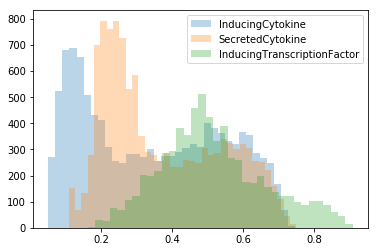

In [5]:
for c in res_pred:
    plt.hist(res_pred[c][1], label=c, bins=36, alpha=.3)
    plt.legend()

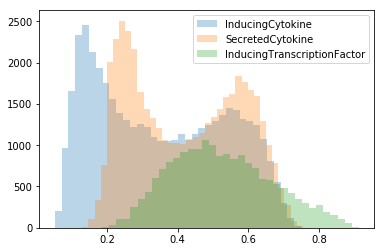

In [3]:
for c in res_pred:
    plt.hist(res_pred[c][1], label=c, bins=36, alpha=.3)
    plt.legend()

### Add Predictions to Candidates

In [4]:
df_ck = pd.read_csv(osp.join(os.environ['META_DATA_DIR'], 'cytokines.csv'))
df_ct = pd.read_csv(osp.join(os.environ['META_DATA_DIR'], 'cell_types.csv'))
df_tf = pd.read_csv(osp.join(os.environ['META_DATA_DIR'], 'transcription_factors.csv'))

m_ct = df_ct.set_index('prefid')['lbl'].to_dict()
m_ck = df_ck.set_index('prefid')['lbl'].to_dict()
m_tf = df_tf.set_index('prefid')['lbl'].to_dict()

# Load doc id -> publishing date dict
m_doc_dt = {
    k: v
    for f in article_data_files
    for k, v in pd.read_csv(f, usecols=['id', 'date'])
    .assign(id=lambda df: 'PMC' + df['id'].astype(str))
    .pipe(lambda df: df[df['date'].notnull()])
    .assign(date=lambda df: pd.to_datetime(df['date']))
    .set_index('id')['date'].to_dict().items()
}

In [5]:
def to_record(cls, c, i, X, Y):
    assert len(X) == len(Y)
    candidate_class = classes[cls]
    typs = candidate_class.entity_types
    m1, m2 = {}, m_ct
    if typs[0] == ENT_TYP_CK.lower():
        m1 = m_ck
    elif typs[0] == ENT_TYP_TF.lower():
        m1 = m_tf
    else:
        raise ValueError('Type "{}" not supported'.format(typs[0]))
    ent1_cid = getattr(c, typs[0] + '_cid')
    ent2_cid = getattr(c, typs[1] + '_cid')
    doc_id = c.get_parent().get_parent().name
    return {
        'type': candidate_class.field, 
        'date': m_doc_dt.get(doc_id, None),
        'doc_id': doc_id, 
        'candidate_id': c.id, 
        'ent1_text': getattr(c, typs[0]).get_span(),
        'ent1_lbl': m1.get(ent1_cid.split(':')[1], None),
        'ent1_cid': ent1_cid, 
        'ent2_text': getattr(c, typs[1]).get_span(),
        'ent2_lbl': m2.get(ent2_cid.split(':')[1], None),
        'ent2_cid': ent2_cid,
        'prob': Y[i]
    }

df = pd.DataFrame([
    to_record(cls, cand, i, res_pred[cls][0], res_pred[cls][1]) 
    for cls in res_pred
    for i, cand in enumerate(res_pred[cls][0])
])
df.head()

,candidate_id,date,doc_id,ent1_cid,ent1_lbl,ent1_text,ent2_cid,ent2_lbl,ent2_text,prob,type
0,31923,2017-07-21,PMC5686050,CKAA6A3321D03ABD23:CK6FE135B3F86FB707,IL-4,interleukin-4,CTE7B12DC660323A0E:CTE7B12DC660323A0E,Th2,Th2,0.240373,inducing_cytokine
1,31924,2017-07-21,PMC5686050,CKAA6A3321D03ABD23:CK6FE135B3F86FB707,IL-4,interleukin-4,CTC3A8C3CBC245616A:CTC3A8C3CBC245616A,Th1,Th1,0.605794,inducing_cytokine
2,31925,2017-07-21,PMC5686050,CKAA6A3321D03ABD23:CK6FE135B3F86FB707,IL-4,interleukin-4,CTE7B12DC660323A0E:CTE7B12DC660323A0E,Th2,Th2,0.419859,inducing_cytokine
3,31926,2017-07-21,PMC5686050,CKAA6A3321D03ABD23:CK6FE135B3F86FB707,IL-4,interleukin-4,CTC3A8C3CBC245616A:CTC3A8C3CBC245616A,Th1,Th1,0.648573,inducing_cytokine
4,31927,2017-07-21,PMC5686050,CKAD8334A7AD4B4D2F:CK6FE135B3F86FB707,IL-4,IL-4,CTE7B12DC660323A0E:CTE7B12DC660323A0E,Th2,Th2,0.228279,inducing_cytokine


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105786 entries, 0 to 105785
Data columns (total 11 columns):
candidate_id    105786 non-null int64
date            105786 non-null datetime64[ns]
doc_id          105786 non-null object
ent1_cid        105786 non-null object
ent1_lbl        105786 non-null object
ent1_text       105786 non-null object
ent2_cid        105786 non-null object
ent2_lbl        105786 non-null object
ent2_text       105786 non-null object
prob            105786 non-null float64
type            105786 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 8.9+ MB


In [7]:
df['type'].value_counts()

inducing_cytokine                43664
secreted_cytokine                43664
inducing_transcription_factor    18458
Name: type, dtype: int64

In [8]:
df['ent2_lbl'].value_counts().sort_values().tail()

Th       4800
Th2     15860
Th1     16864
Treg    20733
Th17    24170
Name: ent2_lbl, dtype: int64

In [9]:
df['ent1_lbl'].value_counts().sort_values().tail()

IL-2      6184
IL-10     6742
TGF-β     7854
IL-4      8736
IFN-γ    11000
Name: ent1_lbl, dtype: int64

## Top Examples by Relation

In [10]:
def get_sentence_html(c, p=None):
    text = c.get_parent().text
    ctx = sorted(c.get_contexts(), key=lambda v: v.char_start)
    c0 = ctx[0].char_start, ctx[0].char_end+1
    c1 = ctx[1].char_start, ctx[1].char_end+1
    assert c0[0] < c1[0] and c0[1] < c1[0]
    
    parts = []
    if p is not None:
        parts += ['<a style="background-color: white">{:.2f}%|&nbsp;</a>'.format(p*100)]
    parts += [
        text[:c0[0]], '<font color="red"><strong>' + text[c0[0]:c0[1]] + '</strong></font>',
        text[c0[1]:c1[0]], '<font color="blue"><strong>' + text[c1[0]:c1[1]] + '</strong></font>',
        text[c1[1]:]
    ]
    return ''.join(parts)

In [11]:
from IPython.display import HTML, display

def get_prediction_html(index, X, Y, limit):
    html = []
    sent_ids = set()
    for i in index:
        sent_id = X[i].get_parent().id
        if sent_id in sent_ids:
            continue
        sent_ids.add(sent_id)
        html.append(get_sentence_html(X[i], p=Y[i]))
        if len(html) >= limit:
            break
    return HTML('<br>'.join(html))
    
limit = 15
for c in res_pred:
    X, Y = res_pred[c][:2]
    o = np.argsort(Y)
    
    display(HTML('<hr>'))
    print('%s (Top %s Highest Predictions):' % (c, limit))
    display(get_prediction_html(o[::-1], X, Y, limit))
    
    display(HTML('<hr>'))
    print('%s (Bottom %s Lowest Predictions):' % (c, limit))
    display(get_prediction_html(o, X, Y, limit))

InducingCytokine (Top 15 Highest Predictions):


InducingCytokine (Bottom 15 Lowest Predictions):


SecretedCytokine (Top 15 Highest Predictions):


SecretedCytokine (Bottom 15 Lowest Predictions):


InducingTranscriptionFactor (Top 15 Highest Predictions):


InducingTranscriptionFactor (Bottom 15 Lowest Predictions):


In [12]:
# from snorkel import viewer
# idx = np.argsort(Y)
# idx = idx[-100:]
# viewer.SentenceNgramViewer(
#     candidates=[X[i] for i in idx], 
#     session=session
# )

## Top Cytokines/TFs by Cell Type

"Enrichment Score": Proportion of papers for a cell type mentioning cytokine/TF divided by same proportion across all **other** cell types

In [13]:
def calculate_scores(df):
    
    def doc_ct(df):
        return df.groupby('ent1_lbl')['doc_id'].nunique().rename('uniq_doc_n')
    
    dfr = []
    for typ in df['type'].unique():
        for ct in df['ent2_lbl'].unique():
            df_tgt = df[(df['type'] == typ) & (df['ent2_lbl'] == ct)]
            df_ctx = df[(df['type'] == typ)]
            dfr.append(
                pd.merge(
                    # Unique doc counts for cell type (tgt) by cytokine/TF 
                    # as well as by cytokine/TF for all cell types (ctx)
                    doc_ct(df_ctx).rename('uniq_docn_ctx').reset_index(),
                    doc_ct(df_tgt).rename('uniq_docn_tgt').reset_index(),
                    on='ent1_lbl',
                    how='outer'
                )
                .fillna(0)
                .assign(
                    type=typ, ent2_lbl=ct,
                    # Unique doc count for cell type (tgt) and all cell types (ctx)
                    uniq_docn_ct_ctx=df_ctx['doc_id'].nunique(),
                    uniq_docn_ct_tgt=df_tgt['doc_id'].nunique()
                )
            )
    dfr = pd.concat(dfr, sort=False)
    assert dfr.notnull().all().all()
    dfr['escore'] = (dfr['uniq_docn_tgt'] / dfr['uniq_docn_ct_tgt']) / (dfr['uniq_docn_ctx'] / dfr['uniq_docn_ct_ctx'])
    return dfr
            

dfp = calculate_scores(df.query('prob > .5'))

dfp.head()

,ent1_lbl,uniq_docn_ctx,uniq_docn_tgt,type,ent2_lbl,uniq_docn_ct_ctx,uniq_docn_ct_tgt,escore
0,4-1BB,5,1.0,inducing_cytokine,Th1,1143,535,0.427290
1,APRIL,4,2.0,inducing_cytokine,Th1,1143,535,1.068224
2,CCL1,4,0.0,inducing_cytokine,Th1,1143,535,0.000000
3,CCL11,1,0.0,inducing_cytokine,Th1,1143,535,0.000000
4,CCL14,1,0.0,inducing_cytokine,Th1,1143,535,0.000000


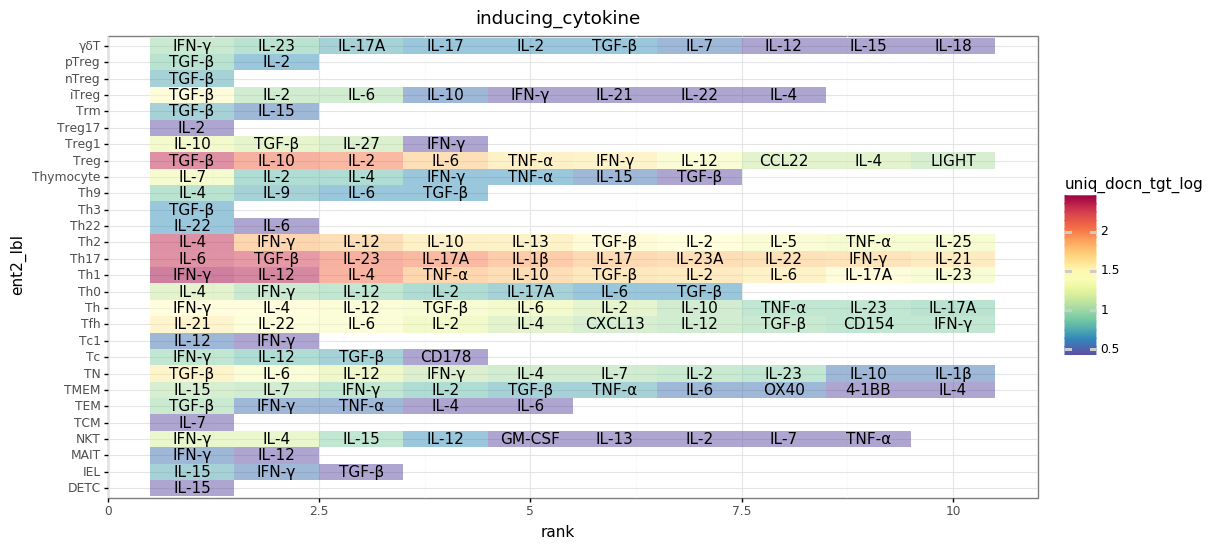

<ggplot: (-9223372036481824873)>

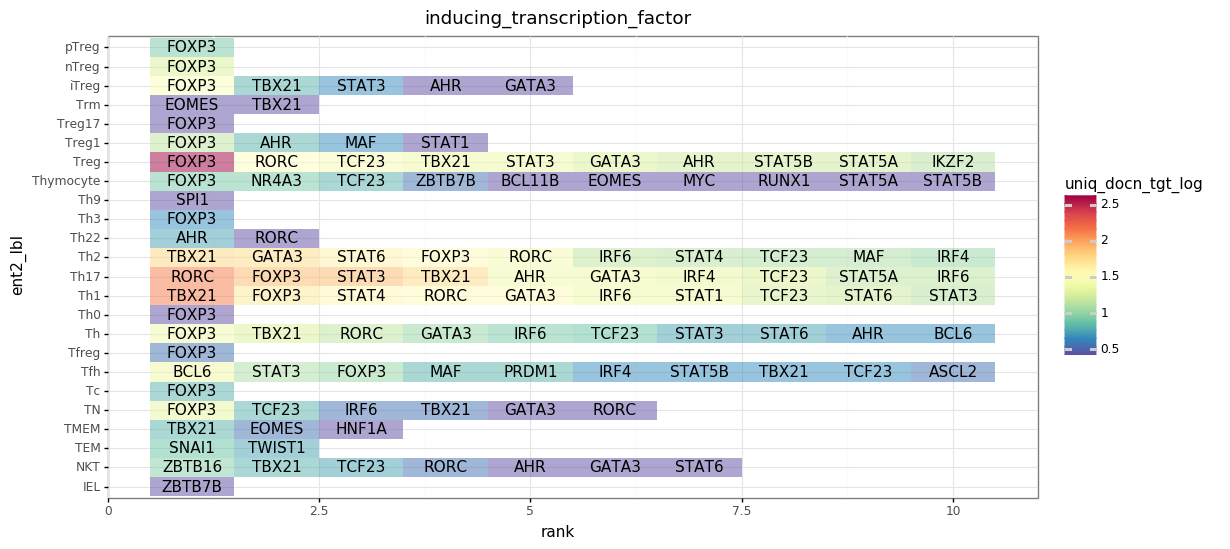

<ggplot: (-9223372036493842260)>

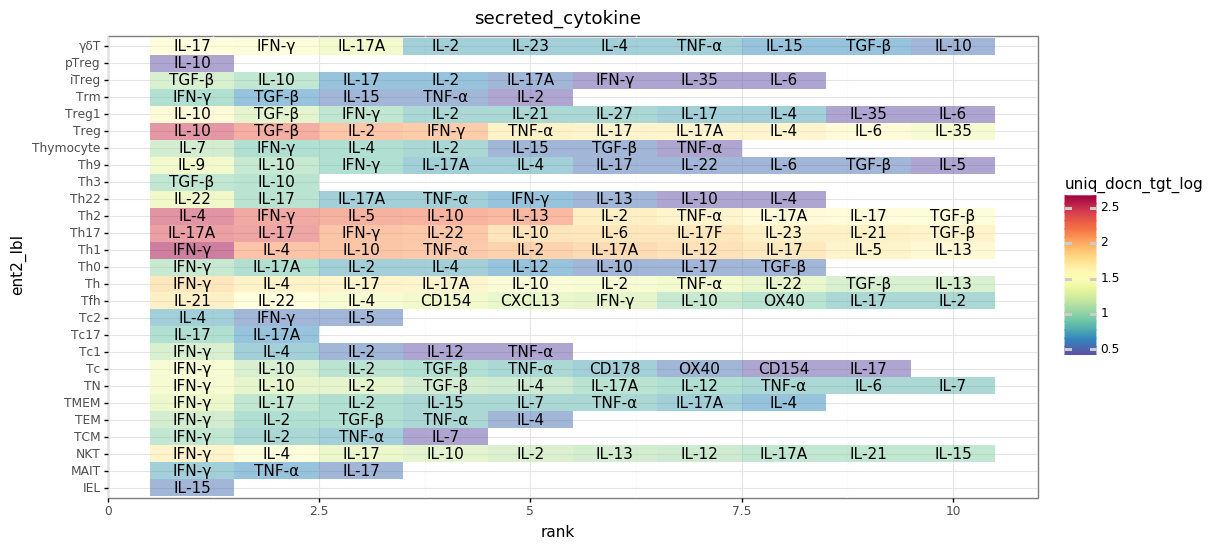

<ggplot: (-9223372036493997708)>

In [14]:
 for k, g in dfp.query('uniq_docn_tgt >= 3').groupby('type'):
    p = (
        pn.ggplot(
            g
            .assign(uniq_docn_tgt_log=np.log10(g['uniq_docn_tgt']))
            .groupby('ent2_lbl').apply(
                lambda g: g.sort_values('uniq_docn_tgt_log', ascending=False)
                .assign(rank=np.arange(1, len(g)+1)).head(10)
            ),
            pn.aes(x='rank', y='ent2_lbl', fill='uniq_docn_tgt_log', label='ent1_lbl')
        ) + 
        pn.geom_tile(alpha=.5) +
        pn.scale_fill_cmap('Spectral_r') +
        pn.geom_text(color='black', alpha=1) +
        pn.ggtitle(k) +
        pn.theme_bw() + 
        pn.theme(figure_size=(12, 6))
    )
    display(p)

In [47]:
# for k, g in dfp.groupby('type'):
#     p = (
#         pn.ggplot(g, pn.aes(x='ent1_lbl', y='uniq_doc_ct')) + 
#         pn.geom_bar(stat='identity', alpha=.3) +
#         pn.facet_wrap('~ ent2_lbl', scales='free', ncol=3, shrink=False) + 
#         pn.labs(title=k) + 
#         pn.coord_flip() +
#         pn.theme_bw() +
#         pn.theme(
#             axis_text_x = pn.element_text(angle = 90, hjust = 0),
#             figure_size=(16, 24)
#         )
#     )
#     display(p)

## Evolution over Time

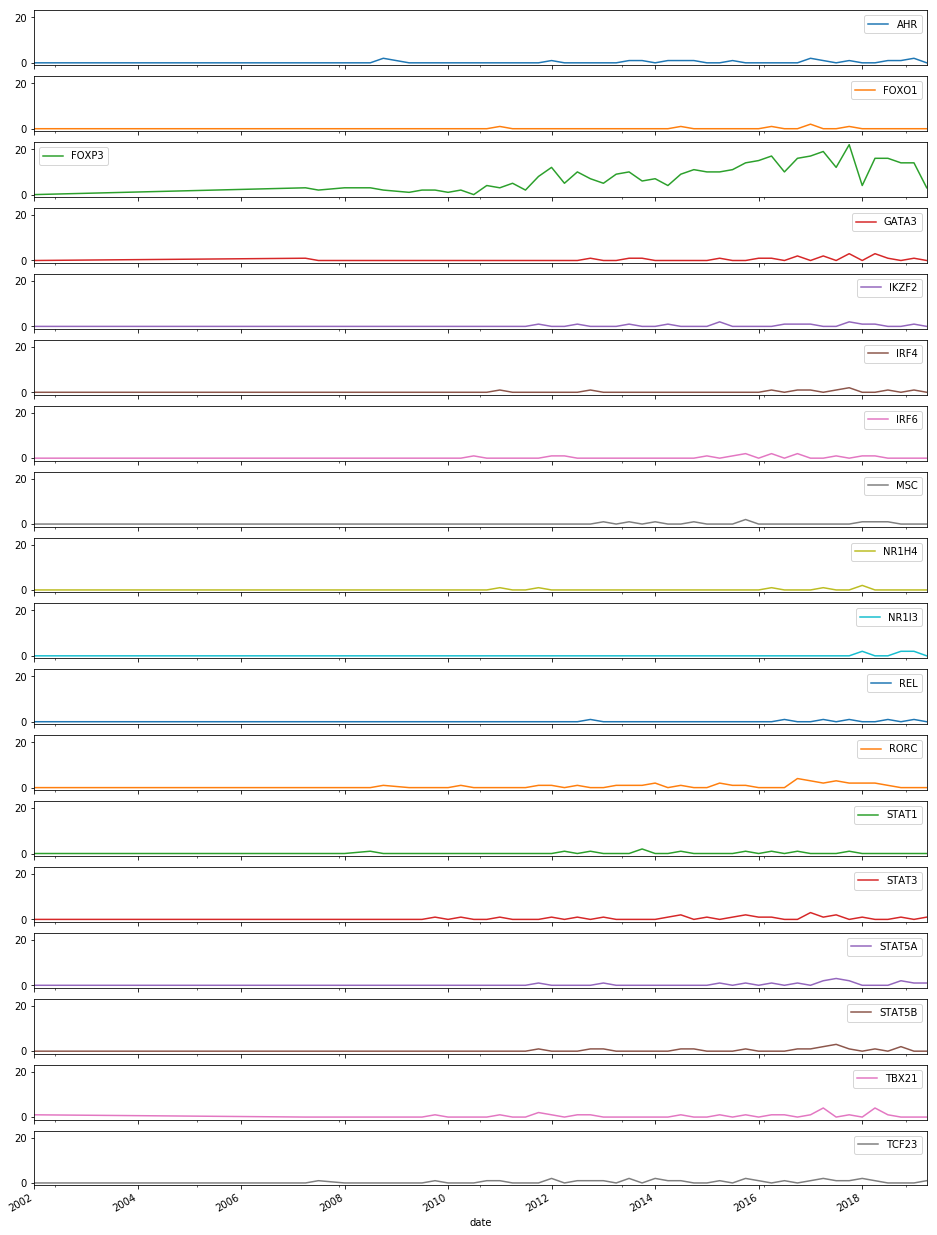

In [15]:
def remove_small_groups(df):
    cts = df.groupby('ent1_lbl')['count'].sum()
    return df[df['ent1_lbl'].isin(cts[cts > 5].index)]

(
    #df.query('prob > .5 & ent2_lbl == "Treg" & type == "secreted_cytokine"')
    #df.query('prob > .5 & ent2_lbl == "Treg" & type == "inducing_cytokine"')
    df.query('prob > .5 & ent2_lbl == "Treg" & type == "inducing_transcription_factor"')
    .groupby(['ent1_lbl', pd.Grouper(key='date', freq='1Q')])['doc_id'].nunique()
    .rename('count').reset_index()
    .pipe(remove_small_groups)
    .pivot(index='date', columns='ent1_lbl', values='count')
    .fillna(0)
    .plot(figsize=(16,24), subplots=True, sharey=True)
)
None

## ImmuneXpresso Comparison

'secreted_cytokine'

In [93]:
def get_ix_data():
    df = pd.read_csv(osp.join(os.environ['SUPERVISION_DATA_DIR'], 'immunexpresso', 'data.csv'))
    df['type'] = None
    df['type'] = np.where(
        (df['actor'] == 'cell') & (df['category'] == 'Positive'), 
        classes.secreted_cytokine.field, 
        df['type']
    )
    df['type'] = np.where(
        (df['actor'] == 'cytokine') & (df['category'] == 'Positive'), 
        classes.inducing_cytokine.field, 
        df['type']
    )
    return df[df['type'].notnull()]
df_ix = get_ix_data()
df_ix.head()

,actor,category,cell_id,cell_label,cytokine_id,cytokine_label,num_papers,score,cell_ref_id,cytokine_ref_id,type
0,cell,Positive,CL_0000084,T cell,CID_83,IFNG,809,4.28,NaN,CK128EC732B281BF60,secreted_cytokine
1,cell,Positive,CL_0000084,T cell,CID_110,IL2,701,5.30,NaN,CKD21834C7D75FD77F,secreted_cytokine
2,cell,Positive,CL_0000625,"CD8-positive, alpha-beta T cell",CID_83,IFNG,338,8.88,NaN,CK128EC732B281BF60,secreted_cytokine
3,cytokine,Positive,CL_0000084,T cell,CID_110,IL2,313,1.58,NaN,CKD21834C7D75FD77F,inducing_cytokine
5,cell,Positive,CL_0000624,"CD4-positive, alpha-beta T cell",CID_83,IFNG,236,5.41,NaN,CK128EC732B281BF60,secreted_cytokine


In [100]:
df_comp = pd.merge((
        df
        .query('prob > .5')
        .assign(ent1_cid=lambda df: df['ent1_cid'].str.split(':').str[1])
        .assign(ent2_cid=lambda df: df['ent2_cid'].str.split(':').str[1])
        .groupby(['type', 'ent1_cid', 'ent1_lbl', 'ent2_cid', 'ent2_lbl'])['doc_id'].nunique()
        .rename('n_docs_snkl').reset_index()
    ), (
        df_ix.groupby(['type', 'cell_ref_id', 'cytokine_ref_id'])['num_papers'].max()
        .rename('n_docs_imxp').reset_index()
        .rename(columns={'cytokine_ref_id': 'ent1_cid', 'cell_ref_id': 'ent2_cid'})
    ),
    on=['type', 'ent1_cid', 'ent2_cid'],
    how='outer'
)
df_comp.head()

,type,ent1_cid,ent1_lbl,ent2_cid,ent2_lbl,n_docs_snkl,n_docs_imxp
0,inducing_cytokine,CK08F84BE8FE5B04F8,IL-17A,CT2AA8AAF80CE1BE08,MAIT,1.0,NaN
1,inducing_cytokine,CK08F84BE8FE5B04F8,IL-17A,CT591AB86BE24D7A57,TN,1.0,NaN
2,inducing_cytokine,CK08F84BE8FE5B04F8,IL-17A,CTB574584AD019ABB8,Treg,2.0,1.0
3,inducing_cytokine,CK08F84BE8FE5B04F8,IL-17A,CTB7DFCED683E6F0A9,Th,3.0,NaN
4,inducing_cytokine,CK08F84BE8FE5B04F8,IL-17A,CTBDDE0043F47EDCC1,Th0,2.0,NaN


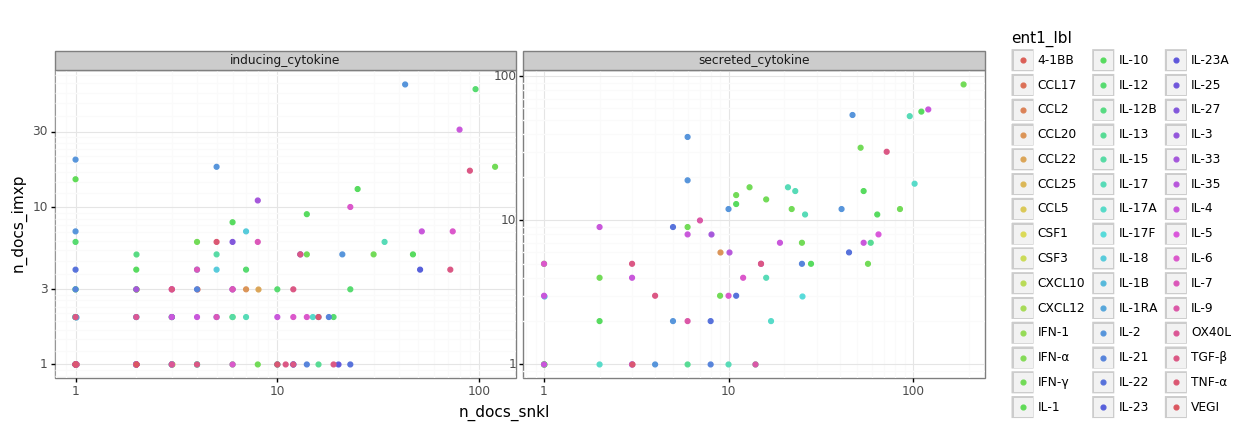

<ggplot: (378154546)>

In [120]:
(
    pn.ggplot(
        df_comp.dropna(), 
        pn.aes(x='n_docs_snkl', y='n_docs_imxp', color='ent1_lbl')
    ) + 
    pn.geom_point() + 
    pn.facet_wrap('~type', scales='free') + 
    pn.scale_x_log10() +
    pn.scale_y_log10() +
    pn.theme_bw() +
    pn.theme(figure_size=(12,4))
)

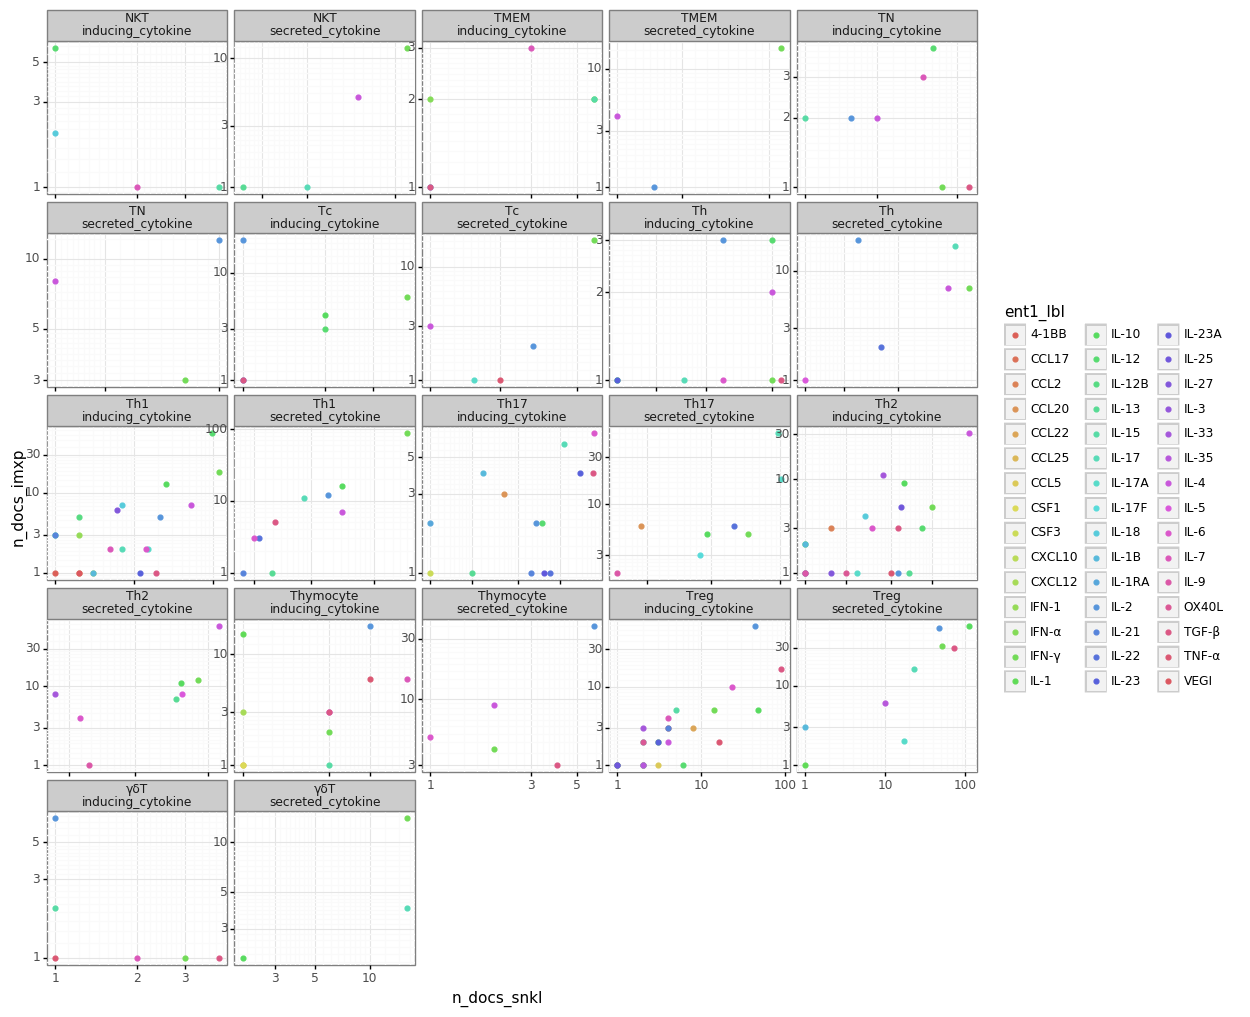

<ggplot: (378346311)>

In [121]:
cts = df_comp.dropna().groupby('ent2_lbl').size() 
(
    pn.ggplot(
        df_comp.dropna().pipe(lambda df: df[df['ent2_lbl'].isin(cts[cts > 5].index)]), 
        pn.aes(x='n_docs_snkl', y='n_docs_imxp', color='ent1_lbl')
    ) + 
    pn.geom_point() + 
    pn.facet_wrap('~ ent2_lbl + type', scales='free') + 
    pn.scale_x_log10() +
    pn.scale_y_log10() +
    pn.theme_bw() +
    pn.theme(figure_size=(12,12))
)

### Export Candidates to BRAT

In [41]:
%run ../src/brat.py
collection_dir = osp.join(os.environ['REPO_DATA_DIR'], 'brat', 'viz', 'train_01')
corpus_docs_dir = osp.join(os.environ['DATA_DIR'], 'articles', 'corpus', 'corpus_00', 'links')
collection_dir, corpus_docs_dir

('/Users/eczech/repos/hammer/t-cell-relation-extraction/pm_subtype_protein_relations/data/brat/viz/train_01',
 '/Users/eczech/data/research/hammer/nlp/20190311-pubmed-tcell-relation/articles/corpus/corpus_00/links')

<Figure size 432x288 with 0 Axes>

In [42]:
def relation_type_fn(c, i, ents):
    proba = Y[i] 
    if proba < .2:
        return c.type + '_low'
    if proba < .8:
        return c.type + '_mid'
    return c.type + '_high'

def text_loader_fn(doc_id):
    with open(osp.join(corpus_docs_dir, doc_id + '.txt')) as fd:
        return fd.read()

In [44]:
bcol = snorkel_candidates_to_brat_collection(
    X, candidate_class.subclass, text_loader_fn, relation_type_fn=relation_type_fn)

In [45]:
bcol.export(collection_dir, styles={
    candidate_class.field + '_low': 'color:red',
    candidate_class.field + '_mid': 'color:orange',
    candidate_class.field + '_high': 'color:green'
}, include_entity_text=False)